# **Uncertainty Project -- Deep Learning**

---

_Fabio TOCCO, Antoine GUIDON, Yelman YAHI, Anis OUEDGHIRI, Ram NADER_


# Imports


In [54]:
import os
import tools
from typing import Literal
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import random_split

import torchvision.datasets as datasets

# Setup


In [2]:
DATA_ROOT = os.path.join(os.path.pardir, "data")
MODELS_ROOT = os.path.join(os.path.pardir, "models")

# Create the directories if they do not exist
os.makedirs(DATA_ROOT, exist_ok=True)
os.makedirs(MODELS_ROOT, exist_ok=True)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Selected device: {DEVICE}")

Selected device: cuda


# Hyperparameters (DO NOT CHANGE)


In [3]:
EPOCHS: int = 20
CRITERION: nn.Module = nn.CrossEntropyLoss()
LEARNING_RATE: float = 1e-4
WEIGHT_DECAY: float = 1e-4
BATCH_SIZE: int = 512

NUM_WORKERS: int = (os.cpu_count() or 0) // 2
print(f"NUM_WORKERS: {NUM_WORKERS}")

NUM_WORKERS: 8


# Parameters (change for different training)


In [4]:
RESIZE_VALUE: int = 32
NORMALIZATION: Literal["MNIST", "ImageNet"] = "MNIST"
SEED: int = 0

tools.seed_everything(seed=SEED)

# Datasets


In [5]:
data_transforms = tools.get_data_transforms(
    data_root=DATA_ROOT, resize_value=RESIZE_VALUE, normalization=NORMALIZATION
)

train_data = datasets.MNIST(
    DATA_ROOT,
    train=True,
    download=True,
    transform=data_transforms,
)
print(f"Number of train samples: {len(train_data)}")

test_data = datasets.MNIST(
    DATA_ROOT,
    train=False,
    download=True,
    transform=data_transforms,
)
print(f"Number of test samples: {len(test_data)}")

num_classes: int = len(train_data.classes)

# Define the validation set by splitting the training data into 2 subsets (80% training and 20% validation)
n_train_samples = int(len(train_data) * 0.8)
n_validation_samples = len(train_data) - n_train_samples
train_data, validation_data = random_split(
    train_data, [n_train_samples, n_validation_samples]
)

Number of train samples: 60000
Number of test samples: 10000


# Experience #1


## DataLoaders


In [6]:
SHUFFLE: bool = False
train_loader, validation_loader, test_loader = tools.get_loaders(
    train_data,
    validation_data,
    test_data,
    shuffle=SHUFFLE,
    batch_size=BATCH_SIZE,
    drop_last=True,
    num_workers=NUM_WORKERS,
)

## Version 1 - Random weights


### Pre-Training


In [7]:
PRETRAINED: bool = False
model = tools.make_resnet18(num_classes, pretrained=PRETRAINED)

OPTIMIZER = torch.optim.Adam(
    model.parameters(),
    lr=LEARNING_RATE,
    weight_decay=WEIGHT_DECAY,
)

model_name = tools.get_model_name(
    pretrained=PRETRAINED, shuffle=SHUFFLE, seed=SEED, normalization="MNIST"
)
model_dir = os.path.join(MODELS_ROOT, model_name)
os.makedirs(model_dir, exist_ok=True)

config = {
    "model": "resnet18",
    "pretrained": PRETRAINED,
    "shuffle": SHUFFLE,
    "seed": SEED,
    "normalization": NORMALIZATION,
    "epochs": EPOCHS,
    "batch_size": BATCH_SIZE,
    "learning_rate": LEARNING_RATE,
    "weight_decay": WEIGHT_DECAY,
    "optimizer": "Adam",
    "criterion": "CrossEntropyLoss",
    "num_train_samples": len(train_data),
    "num_val_samples": len(validation_data),
    "num_test_samples": len(test_data),
}

### Training loop


In [8]:
model, train_losses, validation_losses, validation_accuracies = tools.train_model(
    model=model,
    train_loader=train_loader,
    validation_loader=validation_loader,
    criterion=CRITERION,
    optimizer=OPTIMIZER,
    epochs=EPOCHS,
    device=DEVICE,
    file_path=os.path.join(model_dir, model_name + ".pt"),
    verbose=True,
    save_plots=True,
    config=config,
)

Epoch [1/20] | Train Loss: 0.3149 | Train Acc: 90.69% | Val Loss: 0.0927 | Val Acc: 97.22% | LR: 1.00e-04 | Time: 17.23s
Epoch [2/20] | Train Loss: 0.0483 | Train Acc: 98.70% | Val Loss: 0.0702 | Val Acc: 97.78% | LR: 1.00e-04 | Time: 1.82s
Epoch [3/20] | Train Loss: 0.0137 | Train Acc: 99.80% | Val Loss: 0.0623 | Val Acc: 98.12% | LR: 1.00e-04 | Time: 1.78s
Epoch [4/20] | Train Loss: 0.0042 | Train Acc: 99.98% | Val Loss: 0.0614 | Val Acc: 98.21% | LR: 1.00e-04 | Time: 1.78s
Epoch [5/20] | Train Loss: 0.0018 | Train Acc: 100.00% | Val Loss: 0.0595 | Val Acc: 98.31% | LR: 1.00e-04 | Time: 1.77s
Epoch [6/20] | Train Loss: 0.0011 | Train Acc: 100.00% | Val Loss: 0.0593 | Val Acc: 98.34% | LR: 1.00e-04 | Time: 1.77s
Epoch [7/20] | Train Loss: 0.0008 | Train Acc: 100.00% | Val Loss: 0.0593 | Val Acc: 98.32% | LR: 1.00e-04 | Time: 1.76s
Epoch [8/20] | Train Loss: 0.0006 | Train Acc: 100.00% | Val Loss: 0.0596 | Val Acc: 98.34% | LR: 1.00e-04 | Time: 1.66s
Epoch [9/20] | Train Loss: 0.0005 |

### Visualize results


resnet18_pre-trained_normMNIST_no-shuffle_seed0 -- Loss on test set: 0.0261 | Accuracy on test set: 99.30%


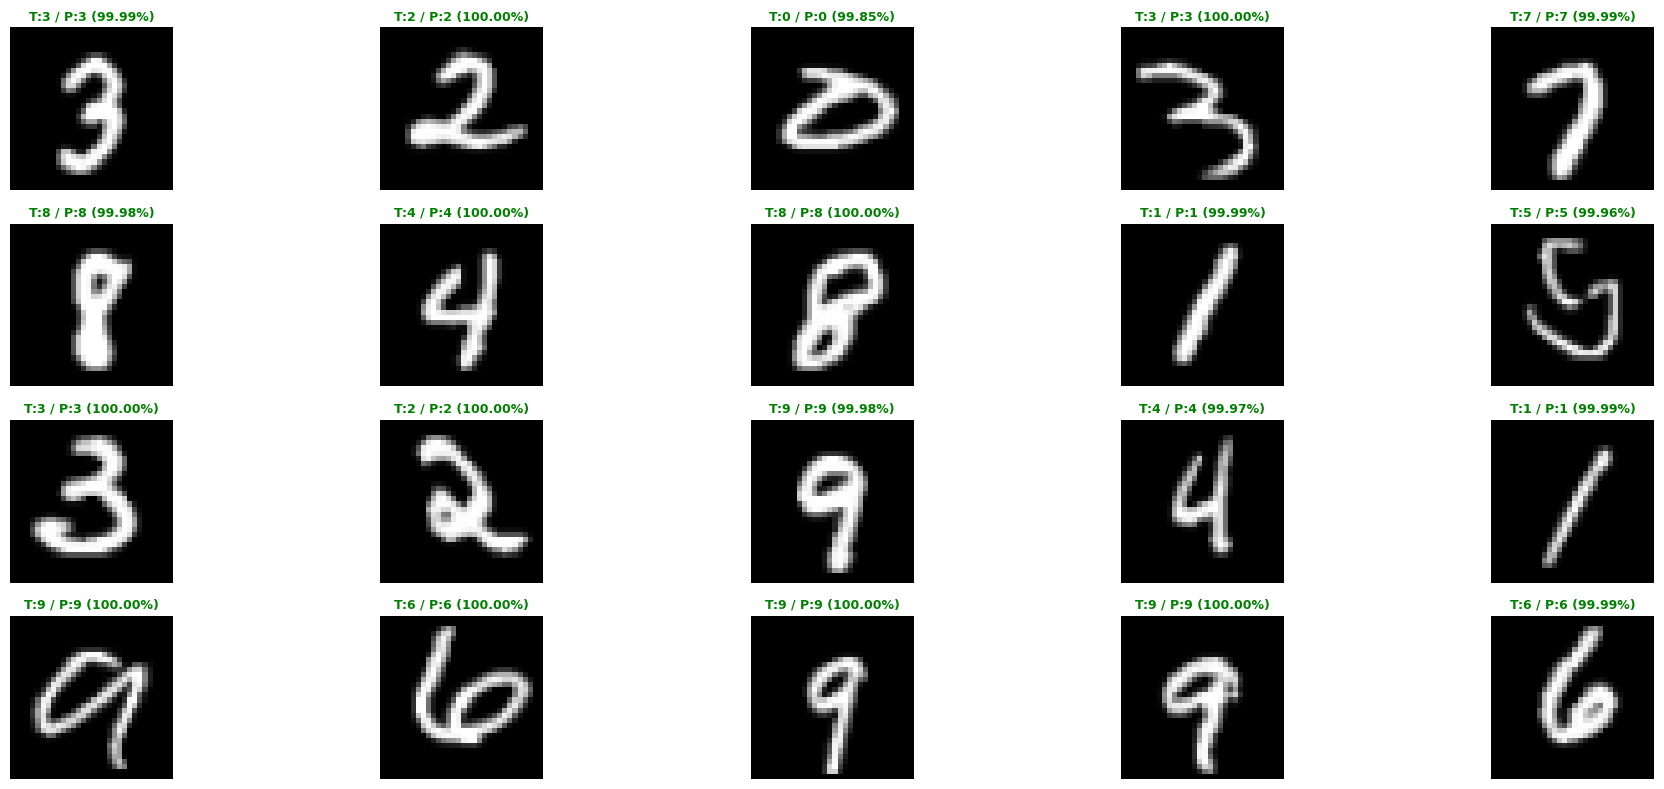

In [29]:
model = tools.load_model(
    model, os.path.join(model_dir, model_name + ".pt"), device=DEVICE
)

test_loss, test_accuracy = tools.evaluate(
    model, test_loader, criterion=CRITERION, device=DEVICE
)
print(
    f"{model_name} -- Loss on test set: {test_loss:.4f} | Accuracy on test set: {100 * test_accuracy:.2f}%",
)

tools.visualize_predictions(
    model=model, dataset=test_data, device=DEVICE, num_samples=20
)
plt.show()

## Version 2 - Pre-trained weights on ImageNet


### Pre-Training


In [30]:
PRETRAINED: bool = True
model = tools.make_resnet18(num_classes, pretrained=PRETRAINED)

OPTIMIZER = torch.optim.Adam(
    model.parameters(),
    lr=LEARNING_RATE,
    weight_decay=WEIGHT_DECAY,
)

model_name = tools.get_model_name(
    pretrained=PRETRAINED, shuffle=SHUFFLE, seed=SEED, normalization=NORMALIZATION
)
model_dir = os.path.join(MODELS_ROOT, model_name)
os.makedirs(model_dir, exist_ok=True)

config = {
    "model": "resnet18",
    "pretrained": PRETRAINED,
    "shuffle": SHUFFLE,
    "seed": SEED,
    "normalization": NORMALIZATION,
    "epochs": EPOCHS,
    "batch_size": BATCH_SIZE,
    "learning_rate": LEARNING_RATE,
    "weight_decay": WEIGHT_DECAY,
    "optimizer": "Adam",
    "criterion": "CrossEntropyLoss",
    "num_train_samples": len(train_data),
    "num_val_samples": len(validation_data),
    "num_test_samples": len(test_data),
}

### Training loop


In [31]:
model, train_losses, validation_losses, validation_accuracies = tools.train_model(
    model=model,
    train_loader=train_loader,
    validation_loader=validation_loader,
    criterion=CRITERION,
    optimizer=OPTIMIZER,
    epochs=EPOCHS,
    device=DEVICE,
    file_path=os.path.join(model_dir, model_name + ".pt"),
    verbose=True,
    save_plots=True,
    config=config,
)

Epoch [1/20] | Train Loss: 0.3077 | Train Acc: 90.91% | Val Loss: 0.0480 | Val Acc: 98.65% | LR: 1.00e-04 | Time: 1.79s
Epoch [2/20] | Train Loss: 0.0274 | Train Acc: 99.19% | Val Loss: 0.0368 | Val Acc: 98.94% | LR: 1.00e-04 | Time: 1.79s
Epoch [3/20] | Train Loss: 0.0077 | Train Acc: 99.84% | Val Loss: 0.0366 | Val Acc: 98.95% | LR: 1.00e-04 | Time: 1.79s
Epoch [4/20] | Train Loss: 0.0026 | Train Acc: 99.98% | Val Loss: 0.0349 | Val Acc: 99.08% | LR: 1.00e-04 | Time: 1.84s
Epoch [5/20] | Train Loss: 0.0012 | Train Acc: 99.99% | Val Loss: 0.0354 | Val Acc: 99.09% | LR: 1.00e-04 | Time: 1.79s
Epoch [6/20] | Train Loss: 0.0007 | Train Acc: 100.00% | Val Loss: 0.0361 | Val Acc: 99.14% | LR: 1.00e-04 | Time: 1.75s
Epoch [7/20] | Train Loss: 0.0005 | Train Acc: 100.00% | Val Loss: 0.0364 | Val Acc: 99.15% | LR: 1.00e-04 | Time: 1.84s
Epoch [8/20] | Train Loss: 0.0004 | Train Acc: 100.00% | Val Loss: 0.0369 | Val Acc: 99.14% | LR: 1.00e-04 | Time: 1.86s
Epoch [9/20] | Train Loss: 0.0003 | T

### Visualize results


resnet18_pre-trained_normMNIST_no-shuffle_seed0 -- Loss on test set: 0.0296 | Accuracy on test set: 99.02%


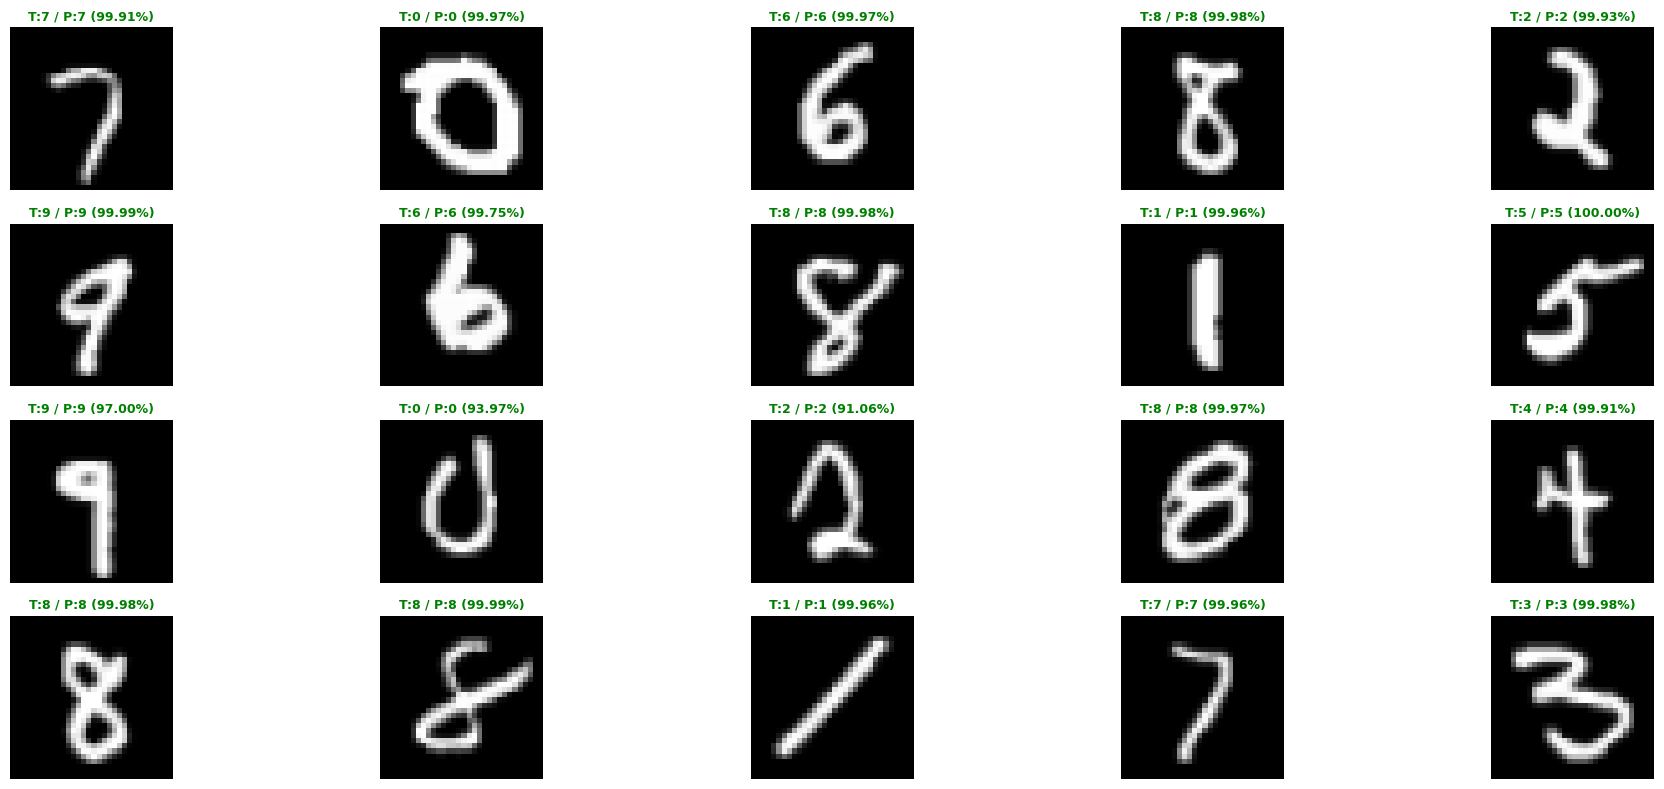

In [46]:
model = tools.load_model(
    model, os.path.join(model_dir, model_name + ".pt"), device=DEVICE
)

test_loss, test_accuracy = tools.evaluate(
    model, test_loader, criterion=CRITERION, device=DEVICE
)
print(
    f"{model_name} -- Loss on test set: {test_loss:.4f} | Accuracy on test set: {100 * test_accuracy:.2f}%",
)

tools.visualize_predictions(
    model=model, dataset=test_data, device=DEVICE, num_samples=20
)
plt.show()

# Experience #2


### Classification Results on 20 Random Test Images

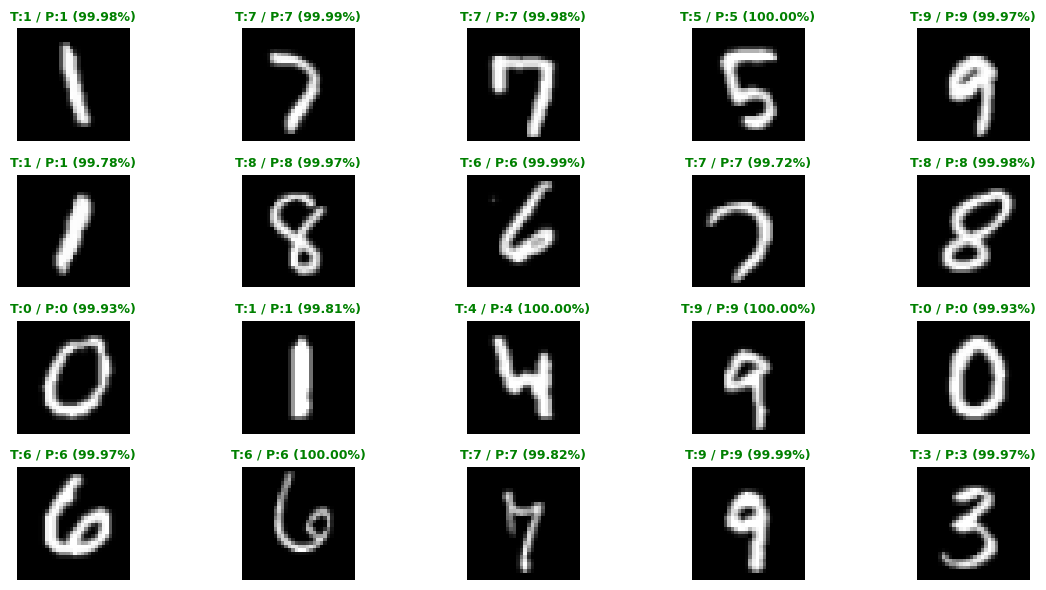

In [42]:
# --- Load the model ---
MODEL_PATH = "../models/resnet18_pre-trained_normMNIST_no-shuffle_seed0/resnet18_pre-trained_normMNIST_no-shuffle_seed0.pt"
model = tools.load_model(model, MODEL_PATH, DEVICE)
model.eval()


# --- Fix a single batch of 20 test images (reproducible) ---
g = torch.Generator()
g.manual_seed(SEED if 'SEED' in globals() else 0)

num_samples = 20
indices = torch.randperm(len(test_data), generator=g)[:num_samples].tolist()

# Retrieve image and label tensors
mnist_sample_images = torch.stack([test_data[i][0] for i in indices])  # (20, 3, H, W)
mnist_sample_labels = torch.tensor([test_data[i][1] for i in indices])  # (20,)
mnist_sample_indices = torch.tensor(indices)  # for traceability


# --- Predictions visualization ---
fig = tools.visualize_predictions(
    model=model,
    device=DEVICE,
    images=mnist_sample_images,
    labels=mnist_sample_labels,
    num_samples=20,
    figsize=(12, 6),
)

### Classification Results on Noisy Images (Different Noise Levels)

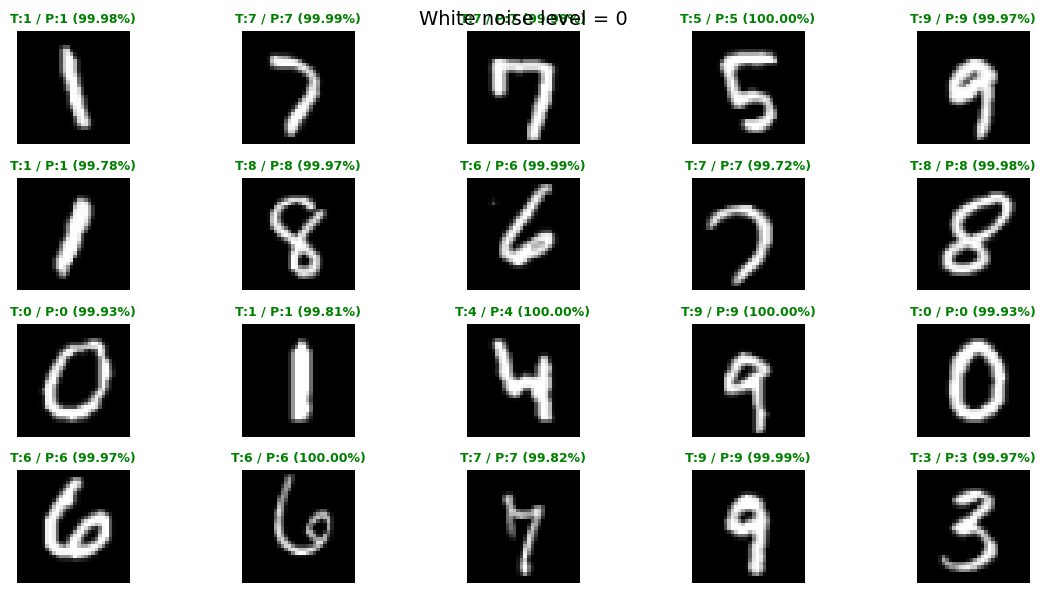

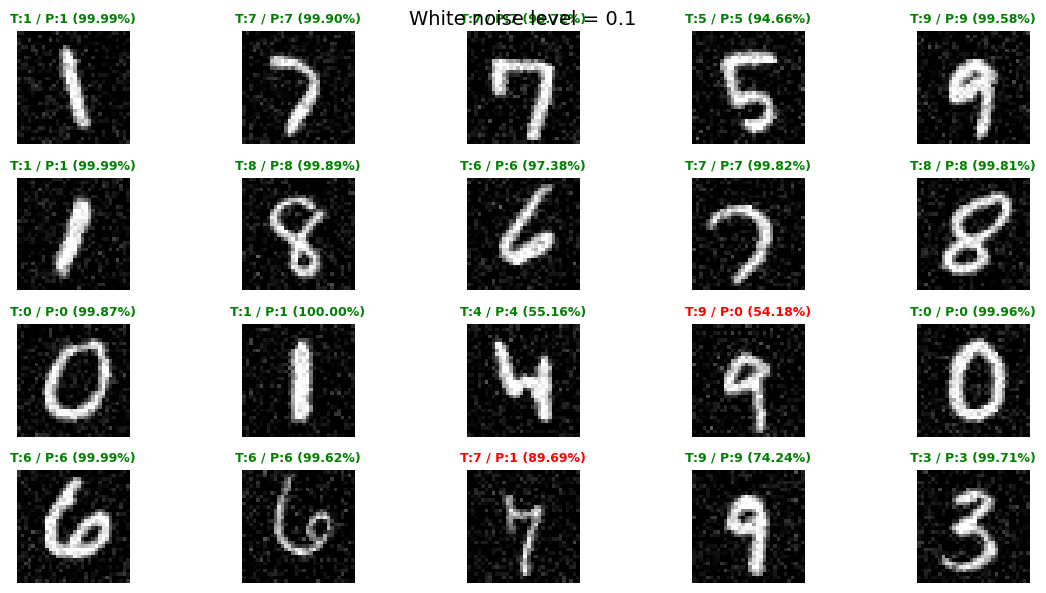

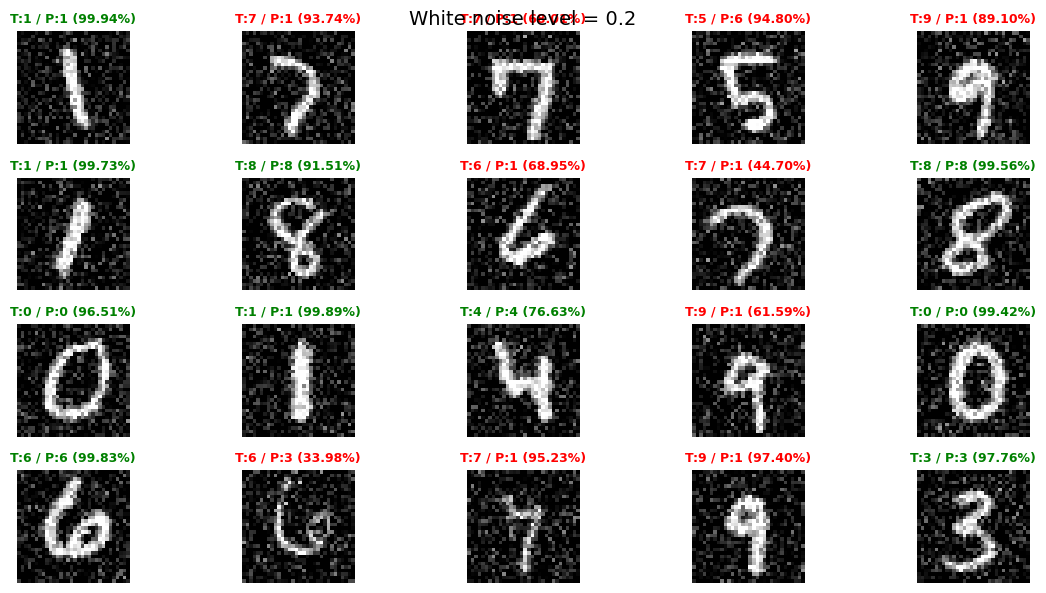

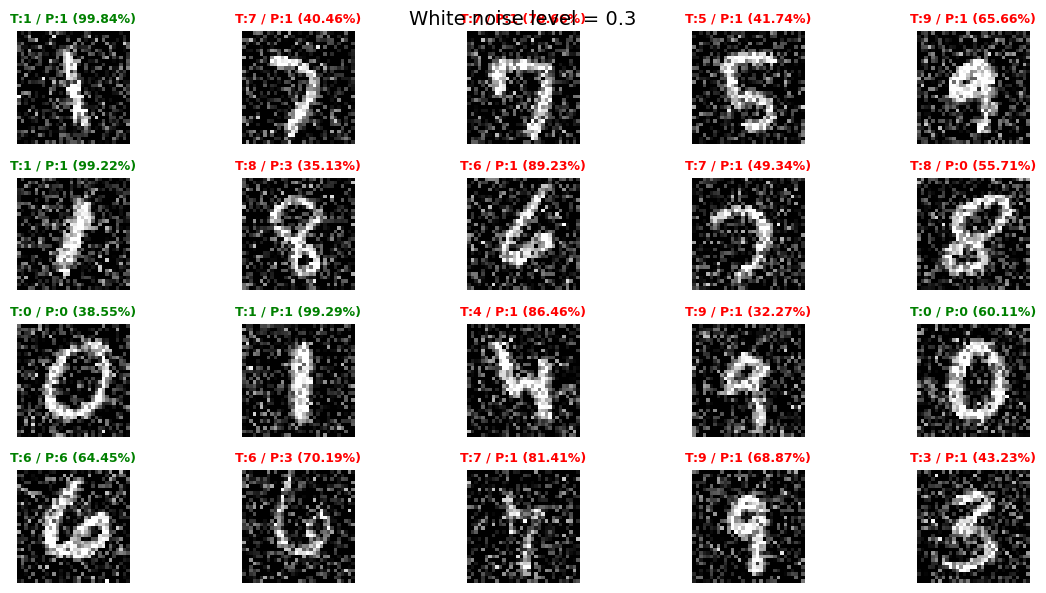

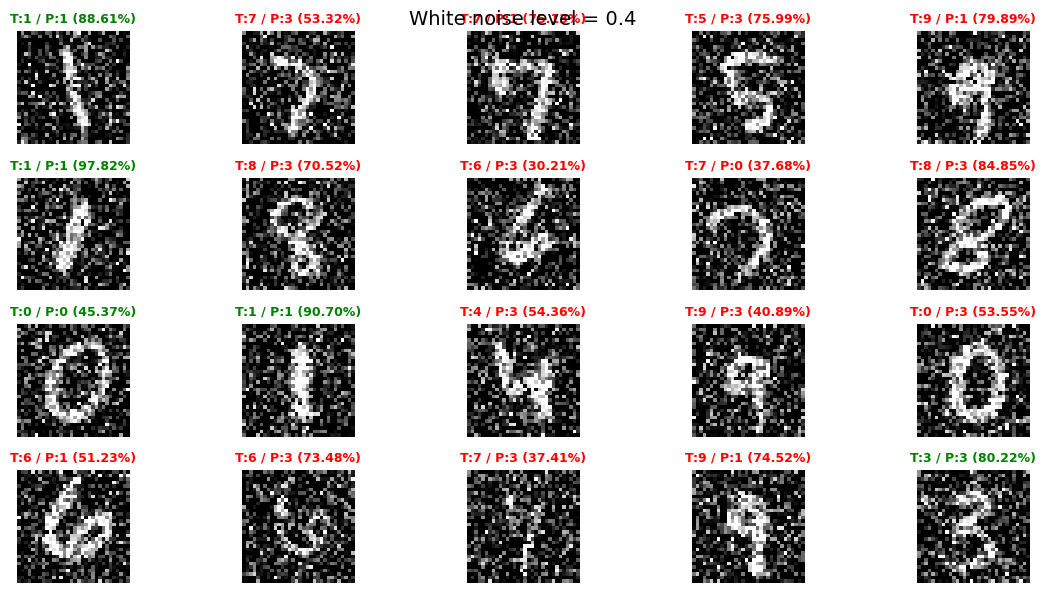

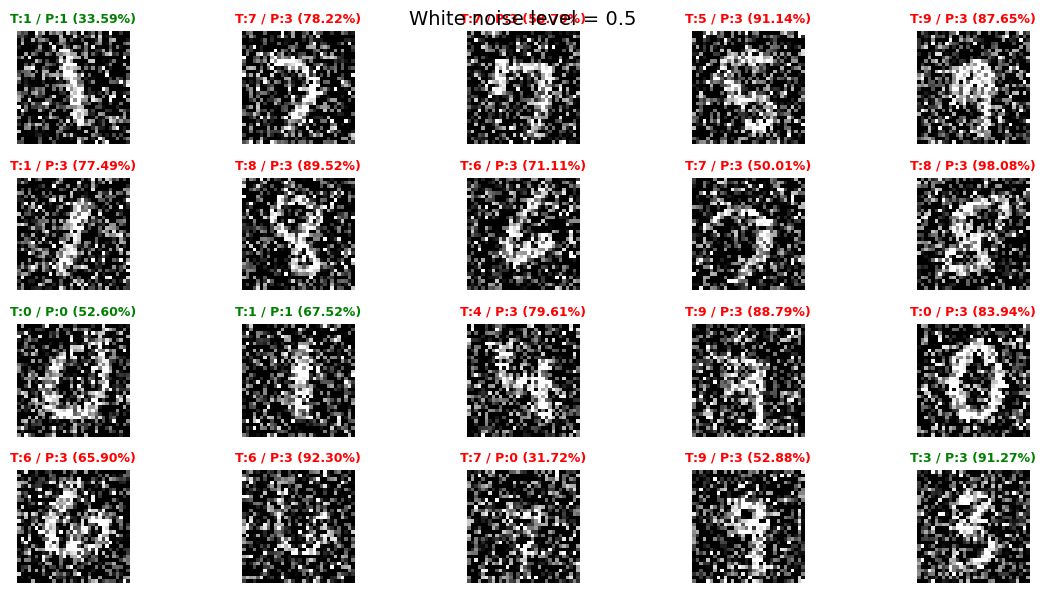

In [ ]:
# --- Define normalization stats (same as training) for applying noise ---
PRETRAINED = False
if PRETRAINED:
    mean = torch.tensor([0.485, 0.456, 0.406], device=DEVICE).view(1, 3, 1, 1)
    std  = torch.tensor([0.229, 0.224, 0.225], device=DEVICE).view(1, 3, 1, 1)
else:
    mean = torch.tensor([0.1307, 0.1307, 0.1307], device=DEVICE).view(1, 3, 1, 1)
    std  = torch.tensor([0.3081, 0.3081, 0.3081], device=DEVICE).view(1, 3, 1, 1)


def add_pixel_noise(x_norm: torch.Tensor,
                    level: float,
                    mean: torch.Tensor,
                    std: torch.Tensor,
                    gray: bool = True):
    # s'assurer que mean/std sont sur le même device que x_norm
    mean = mean.to(x_norm.device)
    std = std.to(x_norm.device)

    x = x_norm * std + mean  # back to [0,1]

    if gray:
        noise = torch.randn(x.size(0), 1, x.size(2), x.size(3), device=x.device).repeat(1, 3, 1, 1)
    else:
        noise = torch.randn_like(x)

    x_noisy = torch.clamp(x + level * noise, 0.0, 1.0)
    return (x_noisy - mean) / std


# --- Predictions visualization ---
noise_levels = [0, 0.1, 0.2, 0.3, 0.4, 0.5]
for level in noise_levels:
    x_noisy = add_pixel_noise(mnist_sample_images, level, mean, std, gray=True)  # keep same noise across channels
    fig = tools.visualize_predictions(
        model=model,
        device=DEVICE,
        images=x_noisy.cpu(),                 # (20, 3, H, W) bruité
        labels=mnist_sample_labels.cpu(),     # (20,)
        num_samples=x_noisy.size(0),          # pour être sûr d’en afficher 20
        figsize=(12, 6),
    )
    fig.suptitle(f"White noise level = {level}", fontsize=14)
    plt.show()
    # fig.savefig(f"mnist_noise_level_{level:.1f}.png", dpi=150, bbox_inches="tight")

# Experience #3


## Create the 7 models


In [58]:
SHUFFLE: bool = False

train_loader, validation_loader, test_loader = tools.get_loaders(
    train_data,
    validation_data,
    test_data,
    shuffle=SHUFFLE,
    batch_size=BATCH_SIZE,
    drop_last=True,
    num_workers=NUM_WORKERS,
)

PRETRAINED: bool = False
model_paths: list[str] = []

for seed in range(1, 8):
    tools.seed_everything(seed=seed)

    model = tools.make_resnet18(num_classes, pretrained=PRETRAINED)

    OPTIMIZER = torch.optim.Adam(
        model.parameters(),
        lr=LEARNING_RATE,
        weight_decay=WEIGHT_DECAY,
    )

    model_name = tools.get_model_name(
        pretrained=PRETRAINED,
        shuffle=SHUFFLE,
        seed=SEED,
        normalization=NORMALIZATION,
        model_number=seed,
    )
    model_dir = os.path.join(MODELS_ROOT, model_name)
    os.makedirs(model_dir, exist_ok=True)

    model_path = os.path.join(model_dir, model_name + ".pt")

    config = {
        "model": "resnet18",
        "pretrained": PRETRAINED,
        "shuffle": SHUFFLE,
        "seed": SEED,
        "normalization": NORMALIZATION,
        "epochs": EPOCHS,
        "batch_size": BATCH_SIZE,
        "learning_rate": LEARNING_RATE,
        "weight_decay": WEIGHT_DECAY,
        "optimizer": "Adam",
        "criterion": "CrossEntropyLoss",
        "num_train_samples": len(train_data),
        "num_val_samples": len(validation_data),
        "num_test_samples": len(test_data),
    }

    print(f"\n Starting training for model {seed}/7 (seed={seed}) | pretrained={PRETRAINED} | shuffle={SHUFFLE}")
    model, train_losses, validation_losses, validation_accuracies = tools.train_model(
        model=model,
        train_loader=train_loader,
        validation_loader=validation_loader,
        criterion=CRITERION,
        optimizer=OPTIMIZER,
        epochs=EPOCHS,
        device=DEVICE,
        file_path=model_path,
        verbose=True,
        save_plots=True,
        config=config,
    )

    model_paths.append(model_path)

    test_loss, test_accuracy = tools.evaluate(
        model, test_loader, criterion=CRITERION, device=DEVICE
    )
    print(
        f"{model_name} -- Loss on test set: {test_loss:.4f} | Accuracy on test set: {100 * test_accuracy:.2f}%",
    )

print(model_paths)


 Starting training for model 1/7 (seed=1) | pretrained=False | shuffle=False
Epoch [1/20] | Train Loss: 0.2994 | Train Acc: 91.20% | Val Loss: 0.0912 | Val Acc: 97.19% | LR: 1.00e-04 | Time: 19.91s
Epoch [2/20] | Train Loss: 0.0470 | Train Acc: 98.61% | Val Loss: 0.0662 | Val Acc: 97.98% | LR: 1.00e-04 | Time: 1.80s
Epoch [3/20] | Train Loss: 0.0134 | Train Acc: 99.78% | Val Loss: 0.0619 | Val Acc: 98.11% | LR: 1.00e-04 | Time: 1.80s
Epoch [4/20] | Train Loss: 0.0041 | Train Acc: 99.97% | Val Loss: 0.0638 | Val Acc: 98.19% | LR: 1.00e-04 | Time: 1.82s
Epoch [5/20] | Train Loss: 0.0018 | Train Acc: 100.00% | Val Loss: 0.0609 | Val Acc: 98.31% | LR: 1.00e-04 | Time: 1.81s
Epoch [6/20] | Train Loss: 0.0010 | Train Acc: 100.00% | Val Loss: 0.0601 | Val Acc: 98.32% | LR: 1.00e-04 | Time: 1.82s
Epoch [7/20] | Train Loss: 0.0007 | Train Acc: 100.00% | Val Loss: 0.0604 | Val Acc: 98.33% | LR: 1.00e-04 | Time: 1.80s
Epoch [8/20] | Train Loss: 0.0006 | Train Acc: 100.00% | Val Loss: 0.0606 | Va

## Observation of classification results


Loaded 7 models.


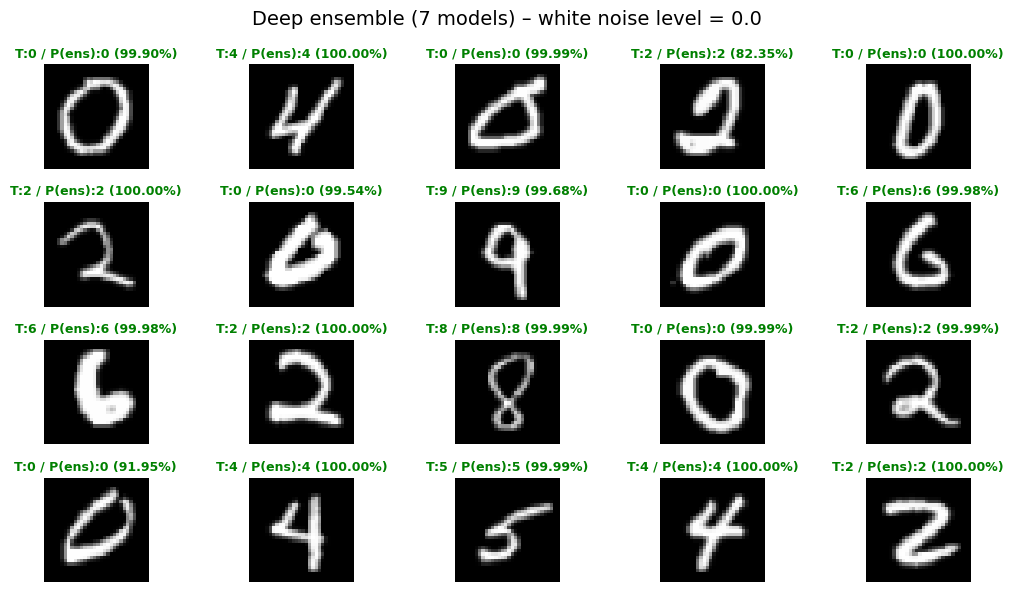

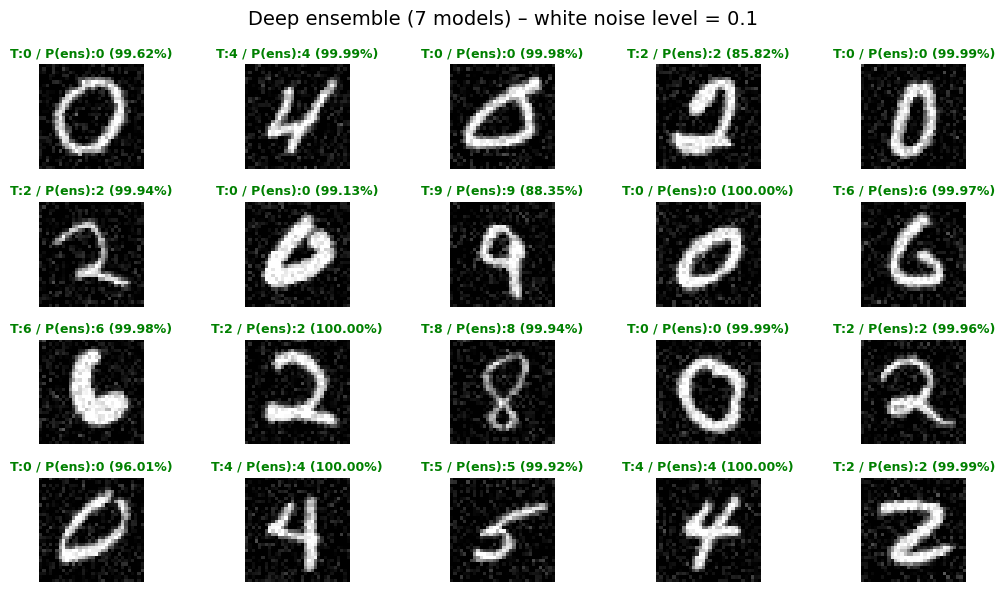

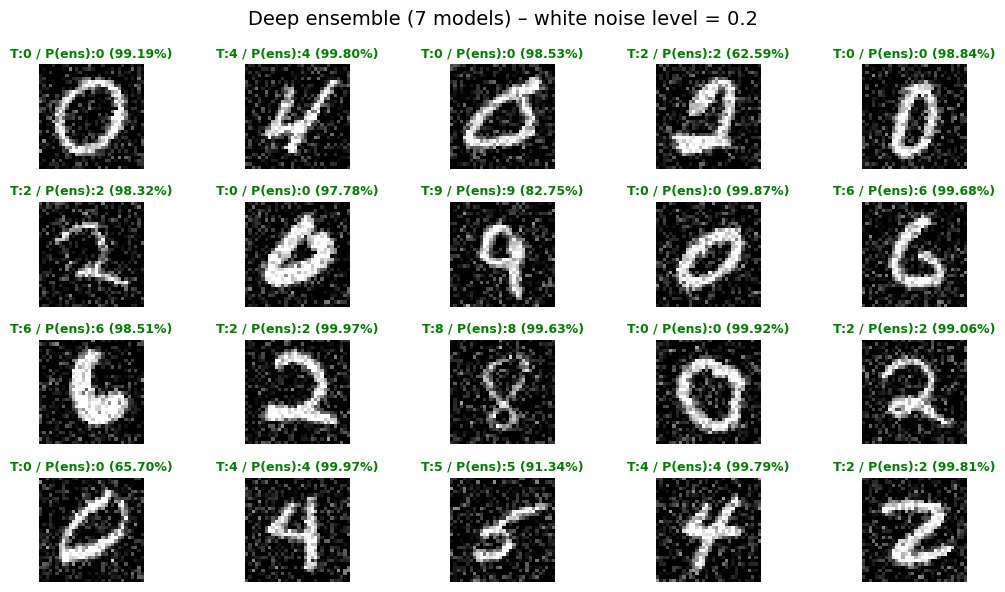

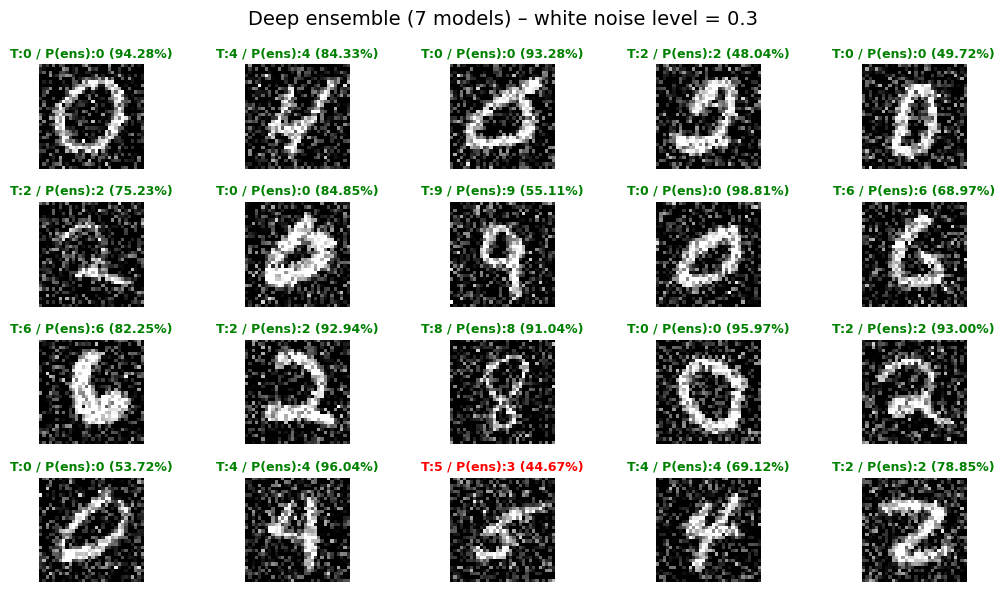

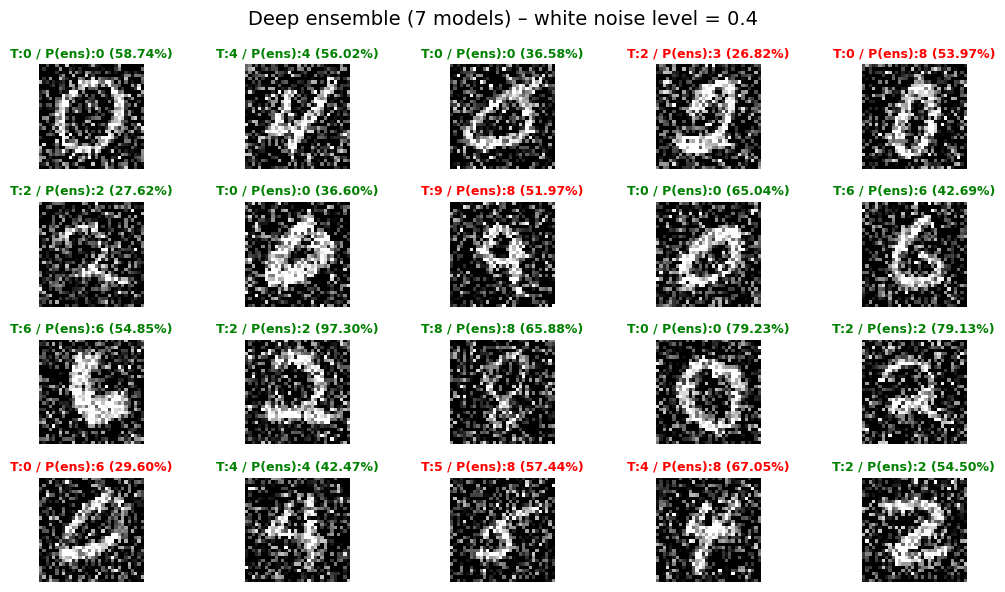

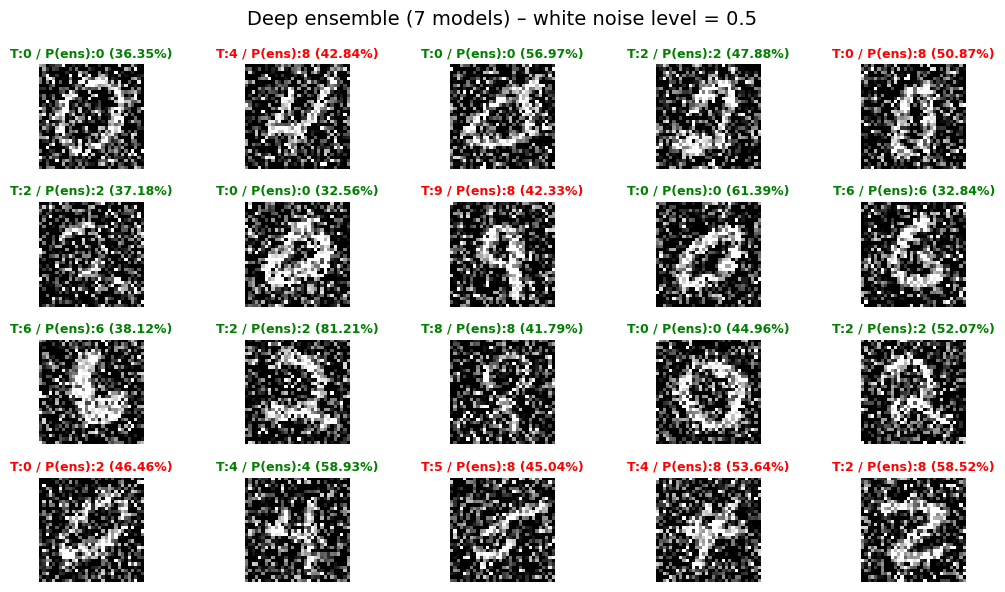

In [59]:
# --- Load the 7 trained models ---
loaded_models: list[torch.nn.Module] = []

for model_path in model_paths:
    # Re-create the same architecture
    m = tools.make_resnet18(num_classes, pretrained=PRETRAINED)
    # Load weights
    m = tools.load_model(m, model_path, DEVICE)
    m.eval()
    loaded_models.append(m)

print(f"Loaded {len(loaded_models)} models.")



# --- Retrieve image and label tensors --- 
# # Fix a single batch of 20 test images (reproducible)
# g = torch.Generator()
# g.manual_seed(SEED if 'SEED' in globals() else 0)

num_samples = 20
indices = torch.randperm(len(test_data), generator=g)[:num_samples].tolist()

mnist_sample_images = torch.stack([test_data[i][0] for i in indices])  # (20, 3, H, W)
mnist_sample_labels = torch.tensor([test_data[i][1] for i in indices]) # (20,)



# --- Predictions visualization ---
def mean_softmax(x: torch.Tensor, models_loaded: list[torch.nn.Module], device: torch.device) -> torch.Tensor:
    """Return the mean softmax probability over all models for a batch x."""
    probs_sum = None
    for m in models_loaded:
        m.eval()
        with torch.no_grad():
            logits = m(x.to(device))
            probs = torch.softmax(logits, dim=1)
        probs_sum = probs if probs_sum is None else probs_sum + probs
    return probs_sum / len(models_loaded)


# --- Visualization with deep ensembles ---
noise_levels = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5]

# Will store ensemble results for later analysis
# ensemble_results[level] = {"preds": ..., "confs": ...}
ensemble_results = {}

for level in noise_levels:
    # 1) create noisy version of the SAME 20 images
    x_noisy = add_pixel_noise(
        mnist_sample_images.to(DEVICE),
        level=level,
        mean=mean,
        std=std,
        gray=True,
    )

    # 2) get ensemble probabilities
    ensemble_probs = mean_softmax(x_noisy, loaded_models, DEVICE)   # (20, num_classes)

    # 3) turn probs into predictions + confidence
    ensemble_preds = ensemble_probs.argmax(dim=1).cpu()             # (20,)
    ensemble_confs = ensemble_probs.max(dim=1).values.cpu()         # (20,)

    # 4) store
    ensemble_results[level] = {
        "preds": ensemble_preds,
        "confs": ensemble_confs,
        "labels": mnist_sample_labels,
        "indices": torch.tensor(indices),
    }

    # 5) visualize ONE grid per noise level (the ensemble view)
    fig = tools.visualize_predictions(
        model=loaded_models[0],           # any model, just to display the images
        device=DEVICE,
        images=x_noisy.cpu(),
        labels=mnist_sample_labels.cpu(),
        num_samples=x_noisy.size(0),
        figsize=(12, 6),
    )
    # After drawing, overwrite titles with ensemble preds
    for i, ax in enumerate(fig.axes):
        if i >= x_noisy.size(0):
            break
        true_label = mnist_sample_labels[i].item()
        pred_label = ensemble_preds[i].item()
        conf = ensemble_confs[i].item()
        correct = (pred_label == true_label)
        color = "green" if correct else "red"
        ax.set_title(f"T:{true_label} / P(ens):{pred_label} ({conf:.2%})",
                     color=color, fontsize=9, fontweight="bold")

    fig.suptitle(f"Deep ensemble (7 models) – white noise level = {level}", fontsize=14)
    plt.tight_layout()
    plt.show()